In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from enum import IntEnum

# prefix = "AMZN_2012-06-21_34200000_57600000"
prefix = "INTC_2012-06-21_34200000_57600000"

trades_data_file = f"./data/{prefix}_message_5.csv"
orderbook_data_file = f"./data/{prefix}_orderbook_5.csv"

trade_df = pd.read_csv(trades_data_file, names=(
    'time',
    'type',
    'orderId',
    'size',
    'price',
    'direction',
),
    skiprows=1
)

orderbook_df = pd.read_csv(orderbook_data_file, names=(
    'ask1_price',
    'ask1_size',
    'bid1_price',
    'bid1_size',

    'ask2_price',
    'ask2_size',
    'bid2_price',
    'bid2_size',

    'ask3_price',
    'ask3_size',
    'bid3_price',
    'bid3_size',

    'ask4_price',
    'ask4_size',
    'bid4_price',
    'bid4_size',

    'ask5_price',
    'ask5_size',
    'bid5_price',
    'bid5_size',
))

df = pd.concat([trade_df, orderbook_df], axis=1)
df['event_lapse'] = df['time'].diff().fillna(0)

df = df[df['type'] != 5]

In [3]:
tick_size = 100

midprice = (df['bid1_price'] + df["ask1_price"]) / 2
midpricePlusTick = midprice + tick_size / 2
midpriceSubTick = midprice - tick_size / 2
spread = df["ask1_price"] - df['bid1_price']

conditions = [
    spread == tick_size,
    df["ask1_price"] >= df['bid1_price'],
    df["ask1_price"] < df['bid1_price']
]

choices = [
    midprice,
    midpricePlusTick,
    midpriceSubTick
]

df['reference_price'] = np.select(conditions, choices)

for n in range(0, 3):
    bid_price_level = df['reference_price'] - (tick_size / 2) - (tick_size * n)
    ask_price_level = df['reference_price'] + (tick_size / 2) + (tick_size * n)

    bid_conditions = [
        bid_price_level == df['bid1_price'],
        bid_price_level == df['bid2_price'],
        bid_price_level == df['bid3_price'],
        bid_price_level == df['bid4_price'],
        bid_price_level == df['bid5_price'],
    ]
    ask_conditions = [
        ask_price_level == df['ask1_price'],
        ask_price_level == df['ask2_price'],
        ask_price_level == df['ask3_price'],
        ask_price_level == df['ask4_price'],
        ask_price_level == df['ask5_price'],
    ]

    bid_choices = [
        df['bid1_size'].astype(float),
        df['bid2_size'].astype(float),
        df['bid3_size'].astype(float),
        df['bid4_size'].astype(float),
        df['bid5_size'].astype(float)
    ]
    ask_choices = [
        df['ask1_size'],
        df['ask2_size'],
        df['ask3_size'],
        df['ask4_size'],
        df['ask5_size']
    ]

    df[f'norm_bid{n + 1}_price'] = bid_price_level
    df[f'norm_ask{n + 1}_price'] = ask_price_level
    df[f'norm_bid{n + 1}_size'] = np.select(bid_conditions, bid_choices)
    df[f'norm_ask{n + 1}_size'] = np.select(ask_conditions, ask_choices)

# print(df['ask1_price'], df['bid1_price'], df['reference_price'])
# print(df)

In [4]:
def seperateOrders(order_queue, depth):
    limitOrder = (order_queue['type'] == 1)
    cancelOrder = (order_queue['type'] == 2) | (order_queue['type'] == 3)
    marketOrderCondititons = (
        (order_queue['type'] == 4) &
        (order_queue[f'norm_bid{depth + 1}_size'] > 0) &
        (order_queue['direction'] == 1)
    )

    return (order_queue[limitOrder], order_queue[cancelOrder], order_queue[marketOrderCondititons])

In [5]:
DEPTH = 3
ORDER_TYPES = 3
BID_INDEX = 0
ASK_INDEX = 1

NORMALIZED_QUEUE_MAX = 50

# Orderbook depth, ordertype (limit, market, cancelation), depth of queue storage we are tracking
lambdas = np.zeros((DEPTH, 2, ORDER_TYPES, NORMALIZED_QUEUE_MAX))

event_in_bid = [
    (df['norm_bid1_price'] == df['price']),
    (df['norm_bid2_price'] == df['price']),
    (df['norm_bid3_price'] == df['price']),
]
event_in_ask = [
    (df['norm_ask1_price'] == df['price']),
    (df['norm_ask2_price'] == df['price']),
    (df['norm_ask3_price'] == df['price']),
]

aes_bids = [
    df[event_in_bid[0]]['size'].mean(),
    df[event_in_bid[1]]['size'].mean(),
    df[event_in_bid[2]]['size'].mean()
]
aes_asks = [
    df[event_in_bid[0]]['size'].mean(),
    df[event_in_bid[1]]['size'].mean(),
    df[event_in_bid[2]]['size'].mean()
]

bids_all_depths = df.loc[event_in_bid[0] | event_in_bid[1] | event_in_bid[2]]
asks_all_depths = df.loc[event_in_ask[0] | event_in_ask[1] | event_in_ask[2]]

dt_orders = np.zeros((DEPTH, NORMALIZED_QUEUE_MAX))

for depth_level in range(0, DEPTH):
    bids_at_depth = df.loc[event_in_bid[depth_level]]
    asks_at_depth = df.loc[event_in_ask[depth_level]]

    bids_at_depth.loc[:, 'queue_length'] = np.ceil(bids_at_depth[f'norm_bid{depth_level + 1}_size'].astype(float) / aes_bids[depth_level])
    asks_at_depth.loc[:, 'queue_length'] = np.ceil(asks_at_depth[f'norm_ask{depth_level + 1}_size'].astype(float) / aes_asks[depth_level])

    # Calculate the time difference ahead of time, aka here, so that we can look at it 
    # since we calculate the queue length and find the mean of other queue length time differences in here.
    # ordersAtDepth['dt_order'] = ordersAtDepth['time'].diff().fillna(0)
    ordersAtDepth = pd.concat([bids_at_depth, asks_at_depth]).sort_values(['time'])
    ordersAtDepth['dt_order'] = ordersAtDepth['time'].diff().fillna(0)

    for queue_index in range(0, NORMALIZED_QUEUE_MAX):

        isBidQueueCurrentLength = (bids_at_depth['queue_length'] == queue_index)
        bid_queue = bids_at_depth.loc[isBidQueueCurrentLength]
        bidLimitOrder, bidCancelOrder, bidMarketOrderCondititons  = seperateOrders(bid_queue, depth_level)

        isAskQueueCurrentLength = (asks_at_depth['queue_length'] == queue_index)
        ask_queue = asks_at_depth.loc[isAskQueueCurrentLength]
        askLimitOrder, askCancelOrder, askMarketOrderCondititons = seperateOrders(ask_queue, depth_level)

        ordersAtQueue = ordersAtDepth.loc[ordersAtDepth['queue_length'] == queue_index]
        numberOfOrdersAtQueue = len(ordersAtQueue)

        dt_order = ordersAtDepth.loc[ordersAtDepth['queue_length'] == queue_index]['dt_order'].mean()

        lambdas[depth_level, BID_INDEX, 0, queue_index] = len(bidLimitOrder) / (numberOfOrdersAtQueue * dt_order)
        lambdas[depth_level, BID_INDEX, 1, queue_index] = len(bidMarketOrderCondititons) / (numberOfOrdersAtQueue * dt_order)
        lambdas[depth_level, BID_INDEX, 2, queue_index] = len(bidCancelOrder) / (numberOfOrdersAtQueue * dt_order)

        lambdas[depth_level, ASK_INDEX, 0, queue_index] = len(askLimitOrder) / (numberOfOrdersAtQueue * dt_order)
        lambdas[depth_level, ASK_INDEX, 1, queue_index] = len(askMarketOrderCondititons) / (numberOfOrdersAtQueue * dt_order)
        lambdas[depth_level, ASK_INDEX, 2, queue_index] = len(askCancelOrder) / (numberOfOrdersAtQueue * dt_order)

C:\Users\trevo\AppData\Local\Temp\ipykernel_7088\2351044262.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bids_at_depth.loc[:, 'queue_length'] = np.ceil(bids_at_depth[f'norm_bid{depth_level + 1}_size'].astype(float) / aes_bids[depth_level])
C:\Users\trevo\AppData\Local\Temp\ipykernel_7088\2351044262.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  asks_at_depth.loc[:, 'queue_length'] = np.ceil(asks_at_depth[f'norm_ask{depth_level + 1}_size'].astype(float) / aes_asks[depth_level])
C:\Users\trevo\A

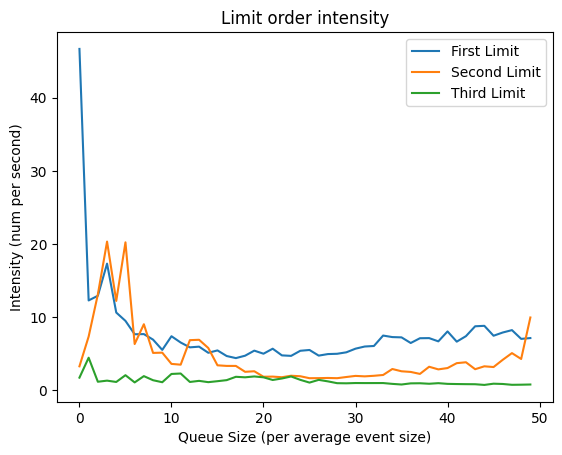

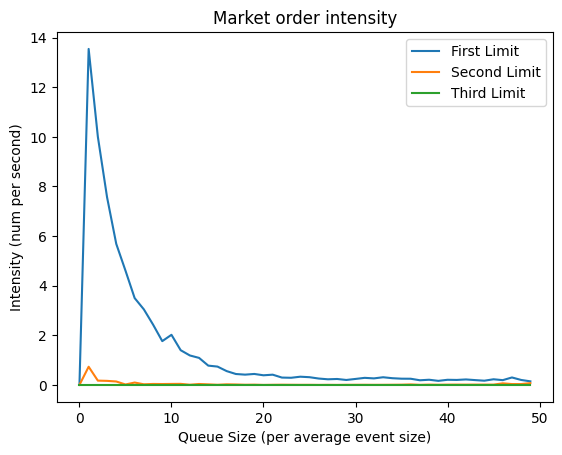

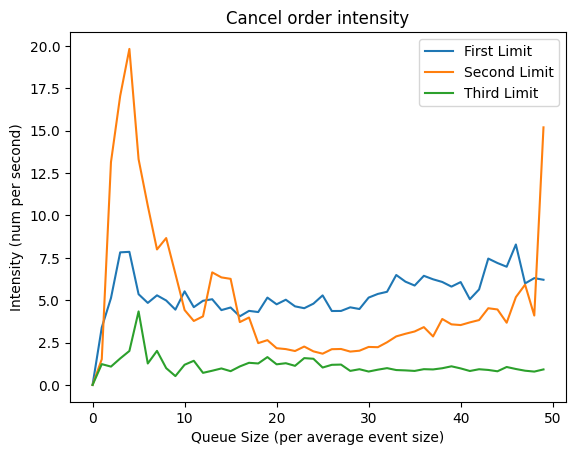

In [6]:
for order_type in range(0, ORDER_TYPES):
    for x in range(0, 2):
        lambdas[0][x][order_type][np.isnan(lambdas[0][x][order_type])] = 0
        lambdas[1][x][order_type][np.isnan(lambdas[1][x][order_type])] = 0
        lambdas[2][x][order_type][np.isnan(lambdas[2][x][order_type])] = 0

    bidIndex = 0
    askIndex = 1

    plt.plot(np.add(lambdas[0][bidIndex][order_type], lambdas[0][askIndex][order_type]), label=f"First Limit")
    plt.plot(np.add(lambdas[1][bidIndex][order_type], lambdas[1][askIndex][order_type]), label=f"Second Limit")
    plt.plot(np.add(lambdas[2][bidIndex][order_type], lambdas[2][askIndex][order_type]), label=f"Third Limit")

    plt.ylabel("Intensity (num per second)")

    plt.xlabel("Queue Size (per average event size)")

    plt.legend()
    
    if (order_type == 0):
        order_name = "Limit"
    elif (order_type == 1):
        order_name = "Market"
    elif (order_type == 2):
        order_name = "Cancel"

    plt.title(f"{order_name} order intensity")

    plt.show()

0.0 0.0 0.9635507285850817
1.7442286336740984 0.0 0.2627865623413859
0.0 0.0 0.9635507285850817
1.7442286336740984 0.0 0.2627865623413859
1.6643148948287774 0.0 0.34052574731776614
2.803056664974783 0.0 0.7402733637342742
0.0 0.0 0.9635507285850817
1.7442286336740984 0.0 0.2627865623413859
1.6643148948287774 0.0 0.34052574731776614
2.803056664974783 0.0 0.7402733637342742
0.5922186909874194 0.0 0.792601223152888
0.5922186909874194 0.0 0.7674392795607328
0.0 0.0 0.9635507285850817
1.7442286336740984 0.0 0.2627865623413859
1.6643148948287774 0.0 0.34052574731776614
2.803056664974783 0.0 0.7402733637342742
0.5922186909874194 0.0 0.792601223152888
0.5922186909874194 0.0 0.7674392795607328
0.5661437308234915 0.0 0.780611543228453
0.7674392795607328 0.0 1.2218267633141005
0.0 0.0 0.9635507285850817
1.7442286336740984 0.0 0.2627865623413859
1.6643148948287774 0.0 0.34052574731776614
2.803056664974783 0.0 0.7402733637342742
0.5922186909874194 0.0 0.792601223152888
0.5922186909874194 0.0 0.7674

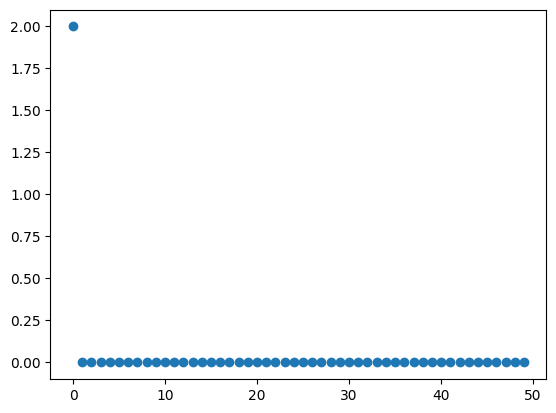

In [7]:
# Invarient Distibutions

def ArrivalDepartureRatio(depth, n, isBid=True):
    limitBid = lambdas[depth][bidIndex][0][n]
    cancelBid = lambdas[depth][bidIndex][1][n + 1]
    marketBid = lambdas[depth][bidIndex][2][n + 1]

    limitAsk = lambdas[depth][askIndex][0][n]
    cancelAsk = lambdas[depth][askIndex][1][n + 1]
    marketAsk = lambdas[depth][askIndex][2][n + 1]

    print(limitBid, cancelBid, marketBid)
    print(limitAsk, cancelAsk, marketAsk)

    if(isBid):
        return limitBid / (cancelBid + marketBid)
    else:
        return limitAsk / (cancelAsk + marketAsk)

def CalculateFirstInvariantTerm(depth, num_of_terms):
    sum = 0

    for n in range(0, num_of_terms):
        product = 1
        for j in range(0, n):
            ratio = ArrivalDepartureRatio(depth, j)
            product *= ratio
        sum += product

    print(1 / (1 + sum))
    return 1 / (1 + sum)

def InvariantDistribution(depth, n, isBid = True):
    product = 1
    for j in range(0, n):
        product *= ArrivalDepartureRatio(depth, j)
    return product / denominator

for depth in range(2, DEPTH):
    denominator = CalculateFirstInvariantTerm(depth, NORMALIZED_QUEUE_MAX)
    print(denominator)

    x_vals = np.linspace(0, NORMALIZED_QUEUE_MAX - 1, NORMALIZED_QUEUE_MAX)
    y_vals = [InvariantDistribution(depth, int(x)) for x in x_vals]

    print(x_vals)
    print(y_vals)

    plt.scatter(x_vals, y_vals)
    plt.show()